In [155]:
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import progressbar
from scipy import stats
sns.set()

%matplotlib inline

# Define path and load files 

Accross the analysis the following names are used for the 3 screens
- ova == Ovariole Number screen
- fec == Hippo RNAi EggLaying screen
- xRNAi == EggLaying screen

In [156]:
data = "../../../Paper/Data"
resultpath = '../../../Paper/Results/'

In [157]:
G = nx.read_graphml(os.path.join(data,'PPI.graphml'))
# G = nx.read_graphml(os.path.join("../../../Data/",'PPI.graphml'))
hipo_ova = pd.read_csv(os.path.join(data,'Screen/hipo_ova_clean.csv'))
xRNAi_fec = pd.read_csv(os.path.join(data,'Screen/xRNAi_fec_clean.csv'))
hipo_fec = pd.read_csv(os.path.join(data,'Screen/hipo_fec_clean.csv'))
signaling = pd.read_csv(os.path.join(data,'signaling.csv'))

In [158]:
# We only consider the sum of eggs layed over 5 days, so we restrict the data to the "Sum"
xRNAi_fec = xRNAi_fec[xRNAi_fec['Condition'] == 'Sum'].reset_index(drop=True)
hipo_fec = hipo_fec[hipo_fec['Condition'] == 'Sum'].reset_index(drop=True)

In [159]:
# Modules computed in the notebook file: Seed-Connector
ova_module_G = nx.read_graphml(os.path.join(resultpath,'Ova_module.graphml'))
fec_module_G = nx.read_graphml(os.path.join(resultpath,'Hpo_EggL_module.graphml'))
xRNAi_module_G = nx.read_graphml(os.path.join(resultpath,'EggL_module.graphml'))
core_module_G = nx.read_graphml(os.path.join(resultpath,'Core_module.graphml'))

# Prepare groups of genes and positive candidate set
Here we calculate the mean of the Zscore for each gene in the screens, define thresholds for significance, and create subsets of genes

In [160]:
mean_ova_gene = hipo_ova.groupby('FbID', as_index=False).mean()
mean_fec_gene = hipo_fec.groupby('FbID', as_index=False).mean()
mean_xRNAi_gene = xRNAi_fec.groupby('FbID', as_index=False).mean()

In [161]:
len([i for i in mean_ova_gene['FbID'].unique() if 'FBgn' in i])

273

In [162]:
ova_module = ova_module_G.nodes()
fec_module = fec_module_G.nodes()
xRNAi_module = xRNAi_module_G.nodes()
core_module = core_module_G.nodes()

In [163]:
# Here we select all the genes that were tested in the screen,
# because the first screen was Hipo RNAi EggLaying measurement, this dataset contains all the tested genes
screen_genes = mean_fec_gene['FbID'].values
ScreenG = G.subgraph(screen_genes)

In [164]:
# We redefine our threshold of 2 and 5 for Z score cutoff
ova_threshold = 2
eggl_threshold = 5

In [165]:
# Ovariole number screen
# Keep only genes with a Zscore over or equal to 2
ova_seed = mean_ova_gene[(mean_ova_gene['Z'].abs()>=ova_threshold)]['FbID'].values
# Filter out the controls
ova_seed = [i for i in ova_seed if 'FBgn' in i]

# Hippo RNAi Egg Laying screen
# Keep only genes with a Zscore over or equal to 5
fec_seed = mean_fec_gene[(mean_fec_gene['Z'].abs()>=eggl_threshold)]['FbID'].values
# Filter out the controls
fec_seed = [i for i in fec_seed if 'FBgn' in i]

# Egg Laying Screen
# Keep only genes with a Zscore over or equal to 5
xRNAi_seed = mean_xRNAi_gene[(mean_xRNAi_gene['Z'].abs()>=eggl_threshold)]['FbID'].values
# Filter out the controls
xRNAi_seed = [i for i in xRNAi_seed if 'FBgn' in i]

core_seed = set.intersection(set(ova_seed), set(fec_seed), set(xRNAi_seed))

In [166]:
connectors = []

for node in ova_module_G.node:
    if "Connector" in ova_module_G.node[node]['Seed']:
        connectors.append(['Ova',node])
for node in fec_module_G.node:
    if "Connector" in fec_module_G.node[node]['Seed']:
        connectors.append(['HpoFec',node])
for node in xRNAi_module_G.node:
    if "Connector" in xRNAi_module_G.node[node]['Seed']:
        connectors.append(['xRNAiFec',node])
for node in core_module_G.node:
    if "Connector" in core_module_G.node[node]['Seed']:
        connectors.append(['Core',node])

connectors = pd.DataFrame(connectors, columns=['Network', 'FbID'])
connectors.to_csv(os.path.join(resultpath,"ConnectorGeneList.csv"), index=False)

In [167]:
print("There is {} unique connectors found accross the 4 network modules".format(len(connectors['FbID'].unique())))

There is 37 unique connectors found accross the 4 network modules


In [168]:
hipo_ova_pred = pd.read_csv(os.path.join(data,'Screen/pred_hipo_ova_clean.csv'))


In [169]:
hipo_ova_pred['FbID'].unique()

array(['FBgn0003944', 'FBgn0261385', 'FBgn0261014', 'FBgn0263108',
       'FBgn0015282', 'FBgn0015268', 'FBgn0031006', 'FBgn0011660',
       'FBgn0034087', 'FBgn0022764', 'FBgn0259896', 'FBgn0003165',
       'Control', 'FBgn0025674', 'FBgn0024846', 'FBgn0004198',
       'FBgn0041627', 'FBgn0004859', 'FBgn0035213', 'FBgn0034753',
       'FBgn0015279', 'FBgn0025463', 'FBgn0038862', 'FBgn0000250',
       'FBgn0005198', 'FBgn0025687', 'FBgn0015805', 'FBgn0003479',
       'FBgn0043903', 'FBgn0031626', 'FBgn0264922', 'FBgn0278604'],
      dtype=object)

In [189]:
ova_seed

['FBgn0000042',
 'FBgn0000117',
 'FBgn0000259',
 'FBgn0000352',
 'FBgn0001139',
 'FBgn0001169',
 'FBgn0001235',
 'FBgn0001624',
 'FBgn0001965',
 'FBgn0002174',
 'FBgn0002592',
 'FBgn0002643',
 'FBgn0003090',
 'FBgn0003124',
 'FBgn0003204',
 'FBgn0003396',
 'FBgn0003444',
 'FBgn0003612',
 'FBgn0003867',
 'FBgn0003892',
 'FBgn0003984',
 'FBgn0004177',
 'FBgn0004647',
 'FBgn0004837',
 'FBgn0004856',
 'FBgn0004858',
 'FBgn0010379',
 'FBgn0010825',
 'FBgn0010909',
 'FBgn0011692',
 'FBgn0014011',
 'FBgn0014020',
 'FBgn0015218',
 'FBgn0015799',
 'FBgn0020386',
 'FBgn0020496',
 'FBgn0021796',
 'FBgn0021874',
 'FBgn0022787',
 'FBgn0023518',
 'FBgn0024248',
 'FBgn0025638',
 'FBgn0025800',
 'FBgn0026181',
 'FBgn0026250',
 'FBgn0026379',
 'FBgn0029175',
 'FBgn0029840',
 'FBgn0030904',
 'FBgn0033266',
 'FBgn0034970',
 'FBgn0036046',
 'FBgn0036974',
 'FBgn0037351',
 'FBgn0038167',
 'FBgn0039102',
 'FBgn0040296',
 'FBgn0044323',
 'FBgn0045035',
 'FBgn0086785',
 'FBgn0259176',
 'FBgn0261592',
 'FBgn02

In [170]:
testedC = """FBgn0000618
FBgn0001218
FBgn0003165
FBgn0003449
FBgn0003460
FBgn0003687
FBgn0003944
FBgn0005655
FBgn0011660
FBgn0013275
FBgn0013334
FBgn0013435
FBgn0014010
FBgn0015019
FBgn0015268
FBgn0015282
FBgn0015553
FBgn0015797
FBgn0020278
FBgn0022764
FBgn0023213
FBgn0024846
FBgn0286198
FBgn0027364
FBgn0027932
FBgn0029897
FBgn0030400
FBgn0031006
FBgn0031089
FBgn0031296
FBgn0032773
FBgn0034087
FBgn0286051
FBgn0037573
FBgn0037874
FBgn0038535
FBgn0039323
FBgn0039735
FBgn0040020
FBgn0040080
FBgn0040153
FBgn0052016
FBgn0085408
FBgn0259152
FBgn0259896
FBgn0261014
FBgn0261385
FBgn0263106
FBgn0263108
FBgn0263396
FBgn0263456
FBgn0025674
FBgn0000546
FBgn0029936""".split()

In [171]:
test = """FBgn0278604
FBgn0038862
FBgn0025463
FBgn0031626
FBgn0015279
FBgn0000250
FBgn0043903
FBgn0004198
FBgn0035213
FBgn0005198
FBgn0264922
FBgn0041627
FBgn0034753
FBgn0025687
FBgn0004859
FBgn0015805
FBgn0022764
FBgn0011660
FBgn0003944
FBgn0024846
FBgn0015268
FBgn0031006
FBgn0263108
FBgn0261385
FBgn0034087
FBgn0015282
FBgn0259896
FBgn0261014
FBgn0025674
FBgn0003165
FBgn0025637
FBgn0031872
FBgn0003444
FBgn0001291
FBgn0003479
FBgn0027535
FBgn0015838""".split()

In [191]:
early_nov_conn = """FBgn0278604
FBgn0038862
FBgn0031872
FBgn0025463
FBgn0031626
FBgn0015279
FBgn0000250
FBgn0025637
FBgn0043903
FBgn0003444
FBgn0004198
FBgn0035213
FBgn0005198
FBgn0264922
FBgn0041627
FBgn0003479
FBgn0027535
FBgn0015838
FBgn0034753
FBgn0025687
FBgn0004859
FBgn0001291
FBgn0015805
FBgn0022764
FBgn0011660
FBgn0003944
FBgn0024846
FBgn0015268
FBgn0031006
FBgn0263108
FBgn0261385
FBgn0034087
FBgn0015282
FBgn0259896
FBgn0261014
FBgn0025674
FBgn0003165""".split()

In [192]:
early_nov_conn

['FBgn0278604',
 'FBgn0038862',
 'FBgn0031872',
 'FBgn0025463',
 'FBgn0031626',
 'FBgn0015279',
 'FBgn0000250',
 'FBgn0025637',
 'FBgn0043903',
 'FBgn0003444',
 'FBgn0004198',
 'FBgn0035213',
 'FBgn0005198',
 'FBgn0264922',
 'FBgn0041627',
 'FBgn0003479',
 'FBgn0027535',
 'FBgn0015838',
 'FBgn0034753',
 'FBgn0025687',
 'FBgn0004859',
 'FBgn0001291',
 'FBgn0015805',
 'FBgn0022764',
 'FBgn0011660',
 'FBgn0003944',
 'FBgn0024846',
 'FBgn0015268',
 'FBgn0031006',
 'FBgn0263108',
 'FBgn0261385',
 'FBgn0034087',
 'FBgn0015282',
 'FBgn0259896',
 'FBgn0261014',
 'FBgn0025674',
 'FBgn0003165']

In [194]:
len(set.intersection(set(early_nov_conn), set(test)))

37

In [172]:
tested = set.union(set(test), set(testedC), set(screen_genes))
len(tested)

527

In [173]:
len(set.intersection(set(tested), set(connectors['FbID'].unique())))

25

In [174]:
set.difference(set(connectors['FbID'].unique()), set(tested))

{'FBgn0000064',
 'FBgn0003041',
 'FBgn0005777',
 'FBgn0010905',
 'FBgn0015774',
 'FBgn0022959',
 'FBgn0034259',
 'FBgn0036790',
 'FBgn0036896',
 'FBgn0037891',
 'FBgn0051679',
 'FBgn0086613'}

In [175]:
len(connectors['FbID'].unique())

37

In [185]:
set.difference(set(connectors['FbID'].unique()), set(tested))

{'FBgn0000064',
 'FBgn0003041',
 'FBgn0005777',
 'FBgn0010905',
 'FBgn0015774',
 'FBgn0022959',
 'FBgn0034259',
 'FBgn0036790',
 'FBgn0036896',
 'FBgn0037891',
 'FBgn0051679',
 'FBgn0086613'}

In [179]:
set.difference(set(test), set(connectors['FbID'].unique()))

{'FBgn0001291',
 'FBgn0003165',
 'FBgn0003944',
 'FBgn0004198',
 'FBgn0004859',
 'FBgn0005198',
 'FBgn0015279',
 'FBgn0015805',
 'FBgn0015838',
 'FBgn0022764',
 'FBgn0025463',
 'FBgn0025674',
 'FBgn0027535',
 'FBgn0031626',
 'FBgn0031872',
 'FBgn0034087',
 'FBgn0034753',
 'FBgn0038862',
 'FBgn0261385',
 'FBgn0278604'}

# Define helper functions

In [21]:
def LCCbootsrap(G, ScreenG, seeds, bootstrapnb=10000):
    subG = G.subgraph(seeds)
    print('Percent found in the PPI:', len(subG.nodes()) / len(seeds))
    print('Graph Size:',len(subG))
    LCC = len(max(nx.connected_components(subG), key=len))
    print('LCC:', LCC)
    
    # Starting BootStrap
    random_LCCs = []
    for i in progressbar.progressbar(range(bootstrapnb)):
        random_nodes = np.random.choice(ScreenG.nodes(), len(subG), replace=False)
        randomG = ScreenG.subgraph(random_nodes)
        random_cc = max(nx.connected_components(randomG), key=len)
        random_LCCs.append(len(random_cc))
    return random_LCCs, LCC

def Edgebootsrap(G, ScreenG, seeds, bootstrapnb=10000):
    subG = G.subgraph(seeds)
    print('Percent found in the PPI:', len(subG.nodes()) / len(seeds))
    print('Graph Size:',len(subG))
    edges = len(subG.edges())
    print('edges:', edges)
    
    # Starting BootStrap
    random_edges = []
    for i in progressbar.progressbar(range(bootstrapnb)):
        random_nodes = np.random.choice(ScreenG.nodes(), len(subG), replace=False)
        randomG = ScreenG.subgraph(random_nodes)
        random_edges.append(len(randomG.edges()))
    return random_edges, edges

def Densitybootsrap(G, ScreenG, seeds, bootstrapnb=10000):
    subG = G.subgraph(seeds)
    print('Percent found in the PPI:', len(subG.nodes()) / len(seeds))
    print('Graph Size:',len(subG))
    density = nx.density(subG)
    print('density:', density)
    
    # Starting BootStrap
    random_density = []
    for i in progressbar.progressbar(range(bootstrapnb)):
        random_nodes = np.random.choice(ScreenG.nodes(), len(subG), replace=False)
        randomG = ScreenG.subgraph(random_nodes)
        random_density.append(nx.density(randomG))
    return random_density, density

def AverageShortestPathbootsrap(G, ScreenG, seeds, bootstrapnb=10000):
    subG = G.subgraph(seeds)
    print('Percent found in the PPI:', len(subG.nodes()) / len(seeds))
    print('Graph Size:',len(subG))
    avg = nx.average_shortest_path_length(max(nx.connected_component_subgraphs(subG), key=len))
    print('AverageShortestPath:', avg)
    
    # Starting BootStrap
    random_avg = []
    for i in progressbar.progressbar(range(bootstrapnb)):
        random_nodes = np.random.choice(ScreenG.nodes(), len(subG), replace=False)
        randomG = ScreenG.subgraph(random_nodes)
        random_avg.append(nx.average_shortest_path_length(max(nx.connected_component_subgraphs(randomG), key=len)))
    return random_avg, avg

def plotNetworkTests(G,ScreenG, seeds, module=None, bootstrapnb=10000, bw=1, full=False):
    random_LCC, LCC = LCCbootsrap(G, ScreenG, seeds, bootstrapnb)
    random_edges, edges = Edgebootsrap(G, ScreenG, seeds, bootstrapnb)
    if full:
        random_density, density = Densitybootsrap(G, ScreenG, seeds, bootstrapnb)
        random_avg, avg = AverageShortestPathbootsrap(G, ScreenG, seeds, bootstrapnb)
    if module:
        random_LCC_module, LCC_module = LCCbootsrap(G, ScreenG, module, bootstrapnb)
        random_Edge_module, Edge_module = Edgebootsrap(G, ScreenG, module, bootstrapnb)
        if full:
            random_density_module, density_module = Densitybootsrap(G, ScreenG, module, bootstrapnb)
            random_avg_module, avg_module = AverageShortestPathbootsrap(G, ScreenG, module, bootstrapnb)

    if full:
        fig = plt.figure(figsize=(5,5))
        row = 2
        col = 2
    else:
        fig = plt.figure(figsize=(7,5))
        row = 1
        col = 2
    
    ax = fig.add_subplot(row, col, 1)
    
    sns.kdeplot(random_LCC, bw=np.std(random_LCC), shade=True, color='lightgray', label="Random bootstrap (PPI)")
    bot, top = ax.get_ylim()
    plt.plot([LCC,LCC], [0,top], 'lightcoral', label='Seed Genes (PPI)')
    if module:
        sns.kdeplot(random_LCC_module, bw=np.std(random_LCC_module), shade=True, color='gray', label="Random bootstrap (PPI)")
        bot, top = ax.get_ylim()
        plt.plot([LCC_module,LCC_module], [0,top], 'darkred', label='Network Module (PPI)')

    plt.title('Largest Connected Component of\nselected genes VS random')
    ax.legend().set_visible(False)
    plt.xlabel('LCC')
    plt.ylabel('Probability Density')
    plt.xlim(0)
    
    ax = fig.add_subplot(row, col, 2)
    sns.kdeplot(random_edges, bw=np.std(random_edges), shade=True, color='lightgray', label="Random bootstrap seed (PPI)")
    bot, top = ax.get_ylim()
    plt.plot([edges,edges], [0,top], 'lightcoral', label='Seed Genes (PPI)')
    if module:
        sns.kdeplot(random_Edge_module, bw=np.std(random_Edge_module), shade=True, color='gray', label="Random bootstrap module (PPI)")
        bot, top = ax.get_ylim()
        plt.plot([Edge_module,Edge_module], [0,top], 'darkred', label='Network Module (PPI)')

    plt.title('Number of interactions of\nselected genes VS random')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Number of Interactions')
    plt.xlim(0)
    
    if full:
        ax = fig.add_subplot(row, col, 3)
        sns.kdeplot(random_density, bw=np.std(random_density), shade=True, color='lightgray', label="Random bootstrap seed (PPI)")
        bot, top = ax.get_ylim()
        plt.plot([density,density], [0,top], 'lightcoral', label='Seed Genes (PPI)')
        if module:
            sns.kdeplot(random_density_module, bw=np.std(random_density_module), shade=True, color='gray', label="Random bootstrap module (PPI)")
            bot, top = ax.get_ylim()
            plt.plot([density_module,density_module], [0,top], 'darkred', label='Network Module (PPI)')

        plt.title('Network density of\nselected genes VS random')
        ax.legend().set_visible(False)
        plt.xlabel('Network density')
        plt.xlim(0)
        
        ax = fig.add_subplot(row, col, 4)
        sns.kdeplot(random_avg, bw=np.std(random_avg), shade=True, color='lightgray', label="Random bootstrap seed (PPI)")
        bot, top = ax.get_ylim()
        plt.plot([avg,avg], [0,top], 'lightcoral', label='Seed Genes (PPI)')
        if module:
            sns.kdeplot(random_avg_module, bw=np.std(random_avg_module), shade=True, color='gray', label="Random bootstrap module (PPI)")
            bot, top = ax.get_ylim()
            plt.plot([avg_module,avg_module], [0,top], 'darkred', label='Network Module (PPI)')

        plt.title('Average shortest path of LCC of\nselected genes VS random')
        ax.legend().set_visible(False)
        plt.xlabel('Average shortest path of LCC')
        plt.xlim(0)        
       
    return fig

# Let's look at the modules and seeds conectivity in the network
This assess whether there is a Network Effect in the group of gene studied. 
It could be seen as an Enrichment test. 
## First I want to make sure that the Screen Genes are not already more connected than random.

In [22]:
# Choose a bootstrap number to run the anlaysis with
bootstrap = 1000

  1% (12 of 1000) |                      | Elapsed Time: 0:00:00 ETA:   0:00:08

Percent found in the PPI: 0.9438444924406048
Graph Size: 437
LCC: 377


100% (1000 of 1000) |####################| Elapsed Time: 0:00:08 Time:  0:00:08
  1% (12 of 1000) |                      | Elapsed Time: 0:00:00 ETA:   0:00:09

Percent found in the PPI: 0.9438444924406048
Graph Size: 437
edges: 1239


100% (1000 of 1000) |####################| Elapsed Time: 0:00:09 Time:  0:00:09
  1% (12 of 1000) |                      | Elapsed Time: 0:00:00 ETA:   0:00:08

Percent found in the PPI: 0.9438444924406048
Graph Size: 437
density: 0.013005689333025424


100% (1000 of 1000) |####################| Elapsed Time: 0:00:09 Time:  0:00:09


Percent found in the PPI: 0.9438444924406048
Graph Size: 437


  0% (3 of 1000) |                       | Elapsed Time: 0:00:00 ETA:   0:00:42

AverageShortestPath: 3.50602460635476


100% (1000 of 1000) |####################| Elapsed Time: 0:00:48 Time:  0:00:48


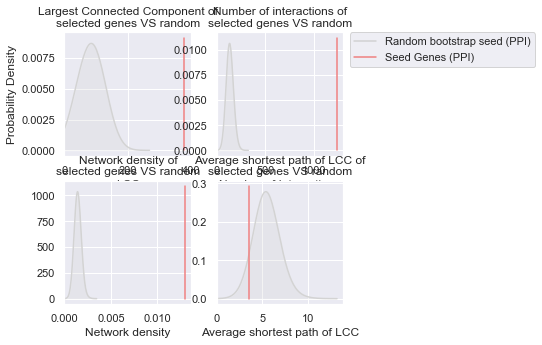

In [23]:
title = "ScreenBackground"
fig = plotNetworkTests(G, G, screen_genes, bootstrapnb=bootstrap, full=True)
fig.savefig(os.path.join(resultpath, 'Figures/NetworkStatistics/{}.svg'.format(title)))
fig.savefig(os.path.join(resultpath, 'Figures/NetworkStatistics/{}.png'.format(title)))

We can see a non negligible network module effect of the signaling genes ... Therefore, we will analyze the modules with this set as a background instead of the whole PPI.

## Network effect of the Ovariole numbers regulators 

  7% (76 of 1000) |#                     | Elapsed Time: 0:00:00 ETA:   0:00:02

Percent found in the PPI: 0.9850746268656716
Graph Size: 66
LCC: 40


100% (1000 of 1000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
  7% (76 of 1000) |#                     | Elapsed Time: 0:00:00 ETA:   0:00:02

Percent found in the PPI: 0.9850746268656716
Graph Size: 66
edges: 51


100% (1000 of 1000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
 10% (102 of 1000) |##                   | Elapsed Time: 0:00:00 ETA:   0:00:02

Percent found in the PPI: 0.9850746268656716
Graph Size: 66
density: 0.023776223776223775


100% (1000 of 1000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
  2% (26 of 1000) |                      | Elapsed Time: 0:00:00 ETA:   0:00:06

Percent found in the PPI: 0.9850746268656716
Graph Size: 66
AverageShortestPath: 4.8538461538461535


100% (1000 of 1000) |####################| Elapsed Time: 0:00:06 Time:  0:00:06
  5% (51 of 1000) |#                     | Elapsed Time: 0:00:00 ETA:   0:00:02

Percent found in the PPI: 1.0
Graph Size: 76
LCC: 73


100% (1000 of 1000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
 10% (102 of 1000) |##                   | Elapsed Time: 0:00:00 ETA:   0:00:02

Percent found in the PPI: 1.0
Graph Size: 76
edges: 98


100% (1000 of 1000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
 10% (102 of 1000) |##                   | Elapsed Time: 0:00:00 ETA:   0:00:02

Percent found in the PPI: 1.0
Graph Size: 76
density: 0.0343859649122807


100% (1000 of 1000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
  2% (26 of 1000) |                      | Elapsed Time: 0:00:00 ETA:   0:00:07

Percent found in the PPI: 1.0
Graph Size: 76
AverageShortestPath: 4.57648401826484


100% (1000 of 1000) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


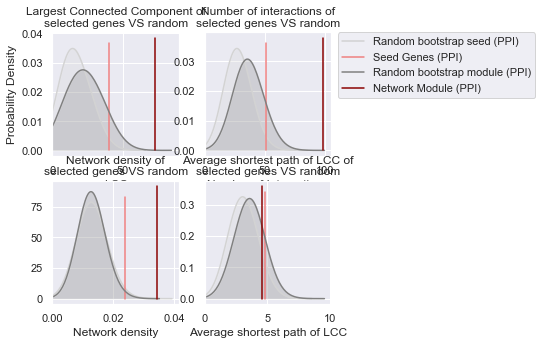

In [24]:
fig = plotNetworkTests(G, ScreenG, ova_seed, ova_module, bootstrapnb=bootstrap, full=True)
title = "OvarioleModule"
fig.savefig(os.path.join(resultpath, 'Figures/NetworkStatistics/{}.svg'.format(title)))
fig.savefig(os.path.join(resultpath, 'Figures/NetworkStatistics/{}.png'.format(title)))

The ovariole regulators for a module within the background set of screened genes

## Network effect of the EggLaying regulators under Hippo RNAi 

  7% (76 of 1000) |#                     | Elapsed Time: 0:00:00 ETA:   0:00:02

Percent found in the PPI: 0.9661016949152542
Graph Size: 57
LCC: 21


100% (1000 of 1000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
  6% (64 of 1000) |#                     | Elapsed Time: 0:00:00 ETA:   0:00:03

Percent found in the PPI: 0.9661016949152542
Graph Size: 57
edges: 31


100% (1000 of 1000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
  7% (76 of 1000) |#                     | Elapsed Time: 0:00:00 ETA:   0:00:02

Percent found in the PPI: 0.9661016949152542
Graph Size: 57
density: 0.019423558897243107


100% (1000 of 1000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
  2% (26 of 1000) |                      | Elapsed Time: 0:00:00 ETA:   0:00:06

Percent found in the PPI: 0.9661016949152542
Graph Size: 57
AverageShortestPath: 3.5714285714285716


100% (1000 of 1000) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
  5% (51 of 1000) |#                     | Elapsed Time: 0:00:00 ETA:   0:00:02

Percent found in the PPI: 1.0
Graph Size: 77
LCC: 76


100% (1000 of 1000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
  7% (76 of 1000) |#                     | Elapsed Time: 0:00:00 ETA:   0:00:02

Percent found in the PPI: 1.0
Graph Size: 77
edges: 106


100% (1000 of 1000) |####################| Elapsed Time: 0:00:03 Time:  0:00:03
  7% (76 of 1000) |#                     | Elapsed Time: 0:00:00 ETA:   0:00:02

Percent found in the PPI: 1.0
Graph Size: 77
density: 0.036226930963773066


100% (1000 of 1000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
  2% (26 of 1000) |                      | Elapsed Time: 0:00:00 ETA:   0:00:07

Percent found in the PPI: 1.0
Graph Size: 77
AverageShortestPath: 3.9589473684210525


100% (1000 of 1000) |####################| Elapsed Time: 0:00:08 Time:  0:00:08


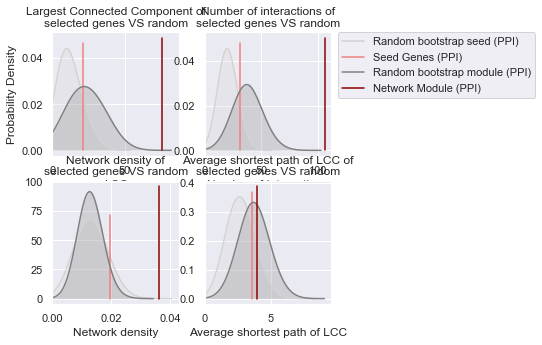

In [25]:
fig = plotNetworkTests(G, ScreenG, fec_seed, fec_module, bootstrapnb=bootstrap, full=True)
title = "HpoRNAiEggL"
fig.savefig(os.path.join(resultpath, 'Figures/NetworkStatistics/{}.svg'.format(title)))
fig.savefig(os.path.join(resultpath, 'Figures/NetworkStatistics/{}.png'.format(title)))

The effect is less strong for the seed genes, but once the module is established, there exist a clear network module 

## Network effect of the EggLaying regulators

  7% (76 of 1000) |#                     | Elapsed Time: 0:00:00 ETA:   0:00:02

Percent found in the PPI: 1.0
Graph Size: 49
LCC: 20


100% (1000 of 1000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
 10% (102 of 1000) |##                   | Elapsed Time: 0:00:00 ETA:   0:00:01

Percent found in the PPI: 1.0
Graph Size: 49
edges: 27


100% (1000 of 1000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
 10% (102 of 1000) |##                   | Elapsed Time: 0:00:00 ETA:   0:00:01

Percent found in the PPI: 1.0
Graph Size: 49
density: 0.02295918367346939


100% (1000 of 1000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
  5% (51 of 1000) |#                     | Elapsed Time: 0:00:00 ETA:   0:00:04

Percent found in the PPI: 1.0
Graph Size: 49
AverageShortestPath: 4.042105263157895


100% (1000 of 1000) |####################| Elapsed Time: 0:00:04 Time:  0:00:04
 15% (152 of 1000) |###                  | Elapsed Time: 0:00:00 ETA:   0:00:01

Percent found in the PPI: 1.0
Graph Size: 62
LCC: 58


100% (1000 of 1000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
 12% (127 of 1000) |##                   | Elapsed Time: 0:00:00 ETA:   0:00:01

Percent found in the PPI: 1.0
Graph Size: 62
edges: 74


100% (1000 of 1000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
 12% (127 of 1000) |##                   | Elapsed Time: 0:00:00 ETA:   0:00:01

Percent found in the PPI: 1.0
Graph Size: 62
density: 0.03913273400317292


100% (1000 of 1000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
  5% (51 of 1000) |#                     | Elapsed Time: 0:00:00 ETA:   0:00:04

Percent found in the PPI: 1.0
Graph Size: 62
AverageShortestPath: 4.257713248638838


100% (1000 of 1000) |####################| Elapsed Time: 0:00:05 Time:  0:00:05


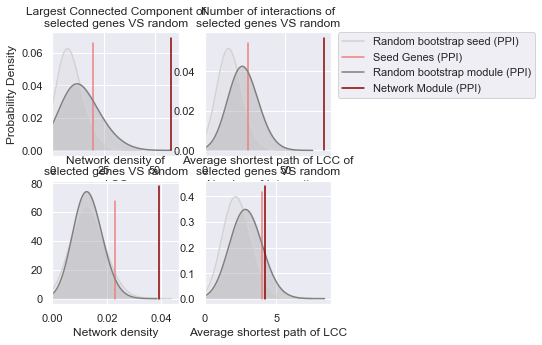

In [26]:
fig = plotNetworkTests(G, ScreenG, xRNAi_seed, xRNAi_module, bootstrapnb=bootstrap, full=True)
title = "EggL"
fig.savefig(os.path.join(resultpath, 'Figures/NetworkStatistics/{}.svg'.format(title)))
fig.savefig(os.path.join(resultpath, 'Figures/NetworkStatistics/{}.png'.format(title)))

The EggLaying regulator with no background have a similar effect than the EggLaying Hippo RNAi. The effect of the seed genes is not as strong, however, once the module is established, there is a strong significant connectivity between the genes.

## Network effect of the core module

 15% (152 of 1000) |###                  | Elapsed Time: 0:00:00 ETA:   0:00:01

Percent found in the PPI: 1.0
Graph Size: 27
LCC: 7


100% (1000 of 1000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01
 14% (140 of 1000) |##                   | Elapsed Time: 0:00:00 ETA:   0:00:01

Percent found in the PPI: 1.0
Graph Size: 27
edges: 10


100% (1000 of 1000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01
 10% (102 of 1000) |##                   | Elapsed Time: 0:00:00 ETA:   0:00:01

Percent found in the PPI: 1.0
Graph Size: 27
density: 0.02849002849002849


100% (1000 of 1000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01
  7% (76 of 1000) |#                     | Elapsed Time: 0:00:00 ETA:   0:00:03

Percent found in the PPI: 1.0
Graph Size: 27
AverageShortestPath: 2.1904761904761907


100% (1000 of 1000) |####################| Elapsed Time: 0:00:03 Time:  0:00:03
 14% (140 of 1000) |##                   | Elapsed Time: 0:00:00 ETA:   0:00:01

Percent found in the PPI: 1.0
Graph Size: 36
LCC: 35


100% (1000 of 1000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01
 12% (127 of 1000) |##                   | Elapsed Time: 0:00:00 ETA:   0:00:01

Percent found in the PPI: 1.0
Graph Size: 36
edges: 47


100% (1000 of 1000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01
 15% (152 of 1000) |###                  | Elapsed Time: 0:00:00 ETA:   0:00:01

Percent found in the PPI: 1.0
Graph Size: 36
density: 0.0746031746031746


100% (1000 of 1000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01
  7% (76 of 1000) |#                     | Elapsed Time: 0:00:00 ETA:   0:00:02

Percent found in the PPI: 1.0
Graph Size: 36
AverageShortestPath: 3.3058823529411763


100% (1000 of 1000) |####################| Elapsed Time: 0:00:03 Time:  0:00:03


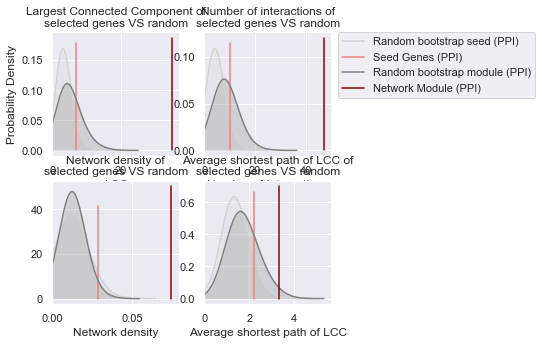

In [27]:
fig = plotNetworkTests(G, ScreenG, core_seed, core_module, bootstrapnb=bootstrap, full=True)
title = "CoreModule"
fig.savefig(os.path.join(resultpath, 'Figures/NetworkStatistics/{}.svg'.format(title)))
fig.savefig(os.path.join(resultpath, 'Figures/NetworkStatistics/{}.png'.format(title)))

The core module has an in between effect, where the seeds are fairly enriched, though within random. But the the module is highly enriched. 